In [1]:
pip install tldextract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
import urllib.parse
import tldextract
import math
import re
from urllib.parse import urlparse
from collections import Counter
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, label_binarize
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.patches as patches
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt 
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, r2_score
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
df = pd.read_csv('/content/malicious_phish.csv')
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [ ]:
df.tail()

,url,type
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing
651190,www.angelfire.com/goth/devilmaycrytonite/,phishing


In [ ]:
df.isnull().sum() # check for missing values

url     0
type    0
dtype: int64

In [ ]:
summary = df.describe()
print(summary)

                                                      url    type
count                                              651191  651191
unique                                             641119       4
top     http://style.org.hc360.com/css/detail/mysite/s...  benign
freq                                                  180  428103


In [ ]:
col = 'type'
freq = df[col].value_counts()
print(freq)

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64


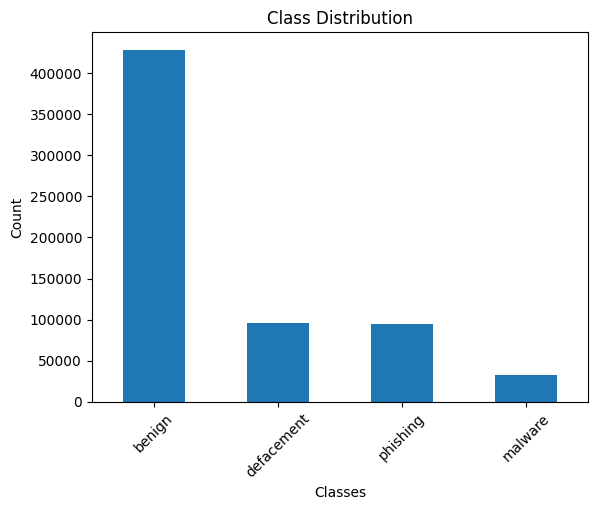

In [ ]:
# Plot the class distribution
freq.plot.bar()
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

In [ ]:
categories = ['defacement', 'malware', 'phishing']

for category in categories:
    print(f"category: {category}")
    malicious_urls = df[df['type'] == category]['url']
    print(malicious_urls)
    print('\n')

category: defacement
3         http://www.garage-pirenne.be/index.php?option=...
4         http://adventure-nicaragua.net/index.php?optio...
8              http://www.pashminaonline.com/pure-pashminas
11        http://www.ikenmijnkunst.nl/index.php/expositi...
13        http://www.lebensmittel-ueberwachung.de/index....
                                ...                        
520294    http://blueanchor.nl/dintelmarkt/page/show_cat...
520302                  http://www.hafenrocker.de/index.php
520305    http://www.kulgupuit.ee/index.php?option=com_p...
520308     http://www.nhomkinhdep.com/tu-bep-nhom-kinh.html
520325    http://www.capella.nl/nl.html?view=article&cat...
Name: url, Length: 96457, dtype: object


category: malware
38        http://www.824555.com/app/member/SportOption.p...
115       http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...
156       http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...
212       http://9779.info/%E5%8F%A4%E4%BB%A3%E4%BA%8C%E...
240       http://ch

In [ ]:
# remove www. from urls
df['url'] = df['url'].replace('www.', '', regex=True)
df

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [ ]:
features = pd.DataFrame()

# extract url length
features['url_length'] = df['url'].apply(len)
features.head()

,url_length
0,16
1,35
2,31
3,84
4,235


In [ ]:
# extract letter count in each URL (excludes symbols and numbers)
features['letter_count'] = df['url'].str.count(r'[a-zA-Z]')
features.head()

,url_length,letter_count
0,16,13
1,35,29
2,31,25
3,84,60
4,235,199


In [ ]:
# extract number count in each URL (excludes symbols and numbers)
features['digit_count'] = df['url'].str.count(r'\d')
features.head()

,url_length,letter_count,digit_count
0,16,13,0
1,35,29,1
2,31,25,1
3,84,60,7
4,235,199,22


In [ ]:
symbols = ['@','?','-','=','.','#','%','+','$','!','*',',','/','//']
symbol_counts = {}

for s in symbols:
    count = df['url'].apply(lambda i: i.count(s)).sum()
    symbol_counts[s] = count

print(symbol_counts)

{'@': 1445, '?': 145725, '-': 1009222, '=': 393230, '.': 1305300, '#': 567, '%': 338287, '+': 44562, '$': 155, '!': 621, '*': 257, ',': 3141, '/': 1920816, '//': 190456}


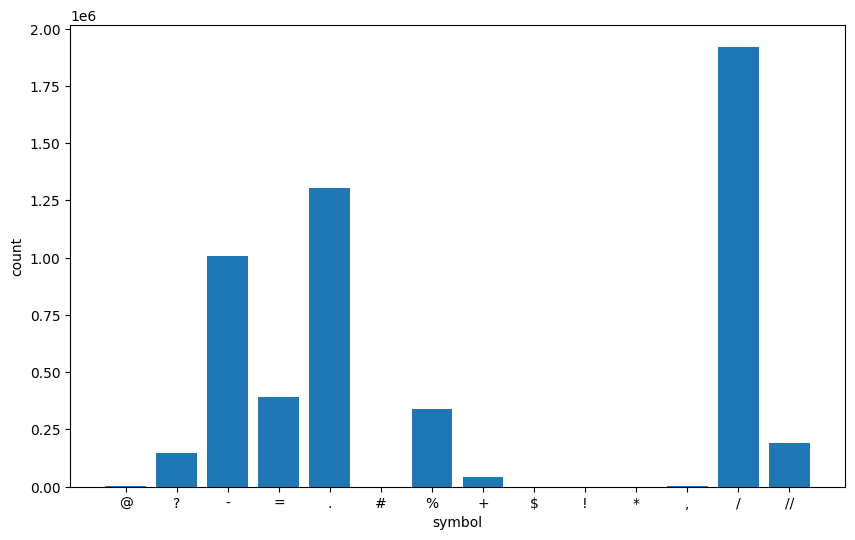

In [ ]:
# visualize symbol frequency
plt.figure(figsize=(10, 6))
plt.bar(symbol_counts.keys(), symbol_counts.values())
plt.xlabel('symbol')
plt.ylabel('count')
plt.show()
# so now we know there are more hyphens and periods

In [ ]:
# add symbols as features
for s in symbols:
    features[s] = df['url'].apply(lambda i: i.count(s))
features.head()

,url_length,letter_count,digit_count,@,?,-,=,.,#,%,+,$,!,*,",",/,//
0,16,13,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0
1,35,29,1,0,0,0,0,2,0,0,0,0,0,0,0,2,0
2,31,25,1,0,0,0,0,2,0,0,0,0,0,0,0,3,0
3,84,60,7,0,1,1,4,2,0,0,0,0,0,0,0,3,1
4,235,199,22,0,1,1,3,2,0,0,0,0,0,0,0,3,1


In [ ]:
# extract length of path (everything after '/')
def path_length(url):
    urlpath= urlparse(url).path # returns '/path'
    try:
        return len(urlpath) # return only characters after 1st '/'
    except:
        return 0

features['path_length'] = df['url'].apply(lambda i: path_length(i))
features.head()

,url_length,letter_count,digit_count,@,?,-,=,.,#,%,+,$,!,*,",",/,//,path_length
0,16,13,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,16
1,35,29,1,0,0,0,0,2,0,0,0,0,0,0,0,2,0,35
2,31,25,1,0,0,0,0,2,0,0,0,0,0,0,0,3,0,31
3,84,60,7,0,1,1,4,2,0,0,0,0,0,0,0,3,1,10
4,235,199,22,0,1,1,3,2,0,0,0,0,0,0,0,3,1,10


In [ ]:
# extract length of first directory (everything after '/' but before the next '/')
def fd_length(url):
    urlpath= urlparse(url).path # returns '/path'
    try:
        return len(urlpath.split('/')[1]) # return only characters between first and second '/'
    except:
        return 0

features['fd_length'] = df['url'].apply(lambda i: fd_length(i))
features.head()

,url_length,letter_count,digit_count,@,?,-,=,.,#,%,+,$,!,*,",",/,//,path_length,fd_length
0,16,13,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,16,0
1,35,29,1,0,0,0,0,2,0,0,0,0,0,0,0,2,0,35,5
2,31,25,1,0,0,0,0,2,0,0,0,0,0,0,0,3,0,31,7
3,84,60,7,0,1,1,4,2,0,0,0,0,0,0,0,3,1,10,9
4,235,199,22,0,1,1,3,2,0,0,0,0,0,0,0,3,1,10,9


In [ ]:
# calculate url entropy (how complex or random the url name is)
# Entropy = -Σ(p * log2(p))
# Lecture 14, Slide 9
def calculate_entropy(s): 
    p, lns = Counter(s), float(len(s)) # Counter() returns a dictionary of character counts
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())
    # high entropy for more complex names

features['url_entropy'] = df['url'].apply(calculate_entropy)
features.head()

,url_length,letter_count,digit_count,@,?,-,=,.,#,%,+,$,!,*,",",/,//,path_length,fd_length,url_entropy
0,16,13,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,16,0,3.375000
1,35,29,1,0,0,0,0,2,0,0,0,0,0,0,0,2,0,35,5,4.079143
2,31,25,1,0,0,0,0,2,0,0,0,0,0,0,0,3,0,31,7,3.708093
3,84,60,7,0,1,1,4,2,0,0,0,0,0,0,0,3,1,10,9,4.635593
4,235,199,22,0,1,1,3,2,0,0,0,0,0,0,0,3,1,10,9,5.491293


<ipython-input-20-6d1582ff74fa>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(features['url_entropy'], shade=True)


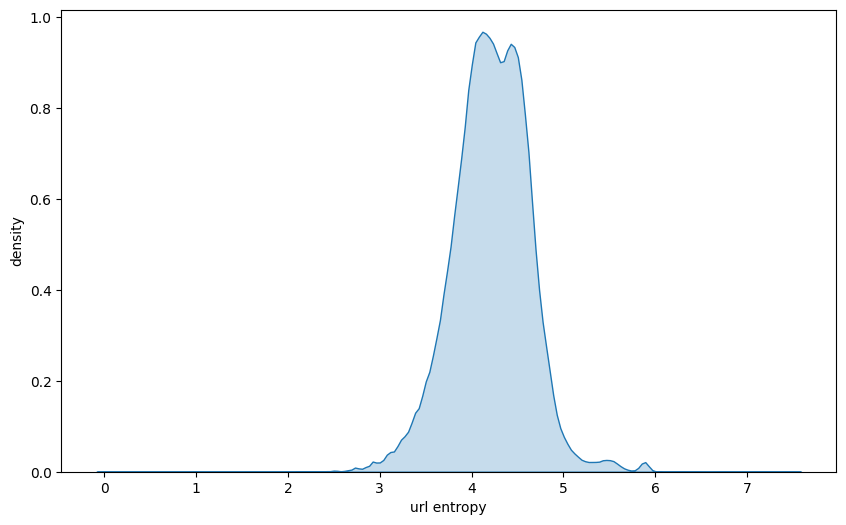

In [ ]:
# visualize domain entropy
# we see higher numbers than hostname because hostname includes many consistent characters such as 'www.' and '.com'
plt.figure(figsize=(10, 6))
sns.kdeplot(features['url_entropy'], shade=True)
plt.xlabel('url entropy')
plt.ylabel('density')
plt.show()

In [ ]:
# extract hostname and length of hostname (e.g., only 'www.domain.com')
features['hostname'] = df['url'].apply(lambda x: urlparse(x).netloc)
features['hostname_length'] = features['hostname'].apply(len)
features.head()

,url_length,letter_count,digit_count,@,?,-,=,.,#,%,...,!,*,",",/,//,path_length,fd_length,url_entropy,hostname,hostname_length
0,16,13,0,0,0,1,0,2,0,0,...,0,0,0,0,0,16,0,3.375000,,0
1,35,29,1,0,0,0,0,2,0,0,...,0,0,0,2,0,35,5,4.079143,,0
2,31,25,1,0,0,0,0,2,0,0,...,0,0,0,3,0,31,7,3.708093,,0
3,84,60,7,0,1,1,4,2,0,0,...,0,0,0,3,1,10,9,4.635593,garage-pirenne.be,17
4,235,199,22,0,1,1,3,2,0,0,...,0,0,0,3,1,10,9,5.491293,adventure-nicaragua.net,23


In [ ]:
# calculate hostname entropy (how complex or random the hostname name is)
# Entropy = -Σ(p * log2(p))
# Lecture 14, Slide 9
def calculate_entropy(s): 
    p, lns = Counter(s), float(len(s)) # Counter() returns a dictionary of character counts
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())
    # high entropy for more complex names

features['hostname_entropy'] = features['hostname'].apply(calculate_entropy)
features.head()

,url_length,letter_count,digit_count,@,?,-,=,.,#,%,...,*,",",/,//,path_length,fd_length,url_entropy,hostname,hostname_length,hostname_entropy
0,16,13,0,0,0,1,0,2,0,0,...,0,0,0,0,16,0,3.375000,,0,0.000000
1,35,29,1,0,0,0,0,2,0,0,...,0,0,2,0,35,5,4.079143,,0,0.000000
2,31,25,1,0,0,0,0,2,0,0,...,0,0,3,0,31,7,3.708093,,0,0.000000
3,84,60,7,0,1,1,4,2,0,0,...,0,0,3,1,10,9,4.635593,garage-pirenne.be,17,3.146286
4,235,199,22,0,1,1,3,2,0,0,...,0,0,3,1,10,9,5.491293,adventure-nicaragua.net,23,3.501398


<ipython-input-23-c7a53ef04238>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(features['hostname_entropy'], shade=True)


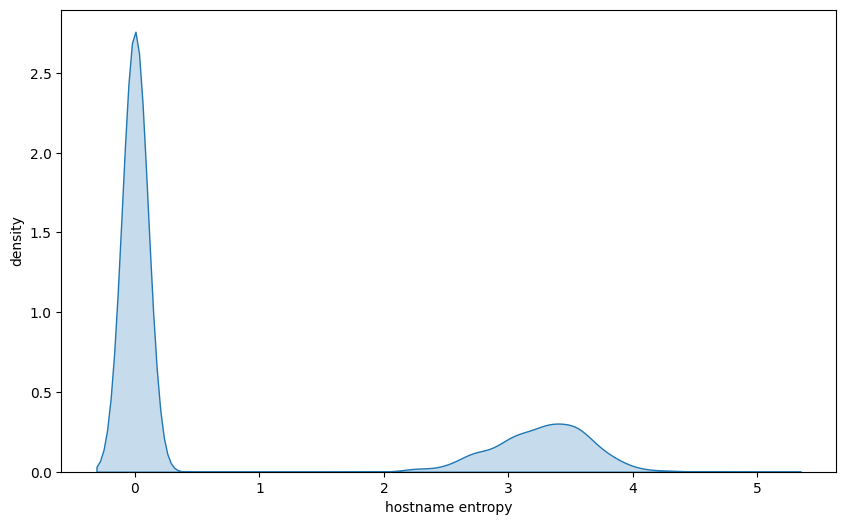

In [ ]:
# visualize hostname entropy
plt.figure(figsize=(10, 6))
sns.kdeplot(features['hostname_entropy'], shade=True)
plt.xlabel('hostname entropy')
plt.ylabel('density')
plt.show()

In [ ]:
# extract domain name and length of domain name (e.g., only 'domain')
features['domain'] = df['url'].apply(lambda x: tldextract.extract(x).domain)
features['domain_length'] = features['domain'].apply(len)
features.head()

,url_length,letter_count,digit_count,@,?,-,=,.,#,%,...,/,//,path_length,fd_length,url_entropy,hostname,hostname_length,hostname_entropy,domain,domain_length
0,16,13,0,0,0,1,0,2,0,0,...,0,0,16,0,3.375000,,0,0.000000,br-icloud,9
1,35,29,1,0,0,0,0,2,0,0,...,2,0,35,5,4.079143,,0,0.000000,mp3raid,7
2,31,25,1,0,0,0,0,2,0,0,...,3,0,31,7,3.708093,,0,0.000000,bopsecrets,10
3,84,60,7,0,1,1,4,2,0,0,...,3,1,10,9,4.635593,garage-pirenne.be,17,3.146286,garage-pirenne,14
4,235,199,22,0,1,1,3,2,0,0,...,3,1,10,9,5.491293,adventure-nicaragua.net,23,3.501398,adventure-nicaragua,19


In [ ]:
# calculate domain entropy (how complex or random the domain name is)
# Entropy = -Σ(p * log2(p))
# Lecture 14, Slide 9
def calculate_entropy(s): 
    p, lns = Counter(s), float(len(s)) # Counter() returns a dictionary of character counts
    return -sum( count/lns * math.log(count/lns, 2) for count in p.values())
    # high entropy for more complex names

features['domain_entropy'] = features['domain'].apply(calculate_entropy)
features.head()

,url_length,letter_count,digit_count,@,?,-,=,.,#,%,...,//,path_length,fd_length,url_entropy,hostname,hostname_length,hostname_entropy,domain,domain_length,domain_entropy
0,16,13,0,0,0,1,0,2,0,0,...,0,16,0,3.375000,,0,0.000000,br-icloud,9,3.169925
1,35,29,1,0,0,0,0,2,0,0,...,0,35,5,4.079143,,0,0.000000,mp3raid,7,2.807355
2,31,25,1,0,0,0,0,2,0,0,...,0,31,7,3.708093,,0,0.000000,bopsecrets,10,2.921928
3,84,60,7,0,1,1,4,2,0,0,...,1,10,9,4.635593,garage-pirenne.be,17,3.146286,garage-pirenne,14,2.896292
4,235,199,22,0,1,1,3,2,0,0,...,1,10,9,5.491293,adventure-nicaragua.net,23,3.501398,adventure-nicaragua,19,3.405822


<ipython-input-26-f6a64dcda2be>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(features['domain_entropy'], shade=True)


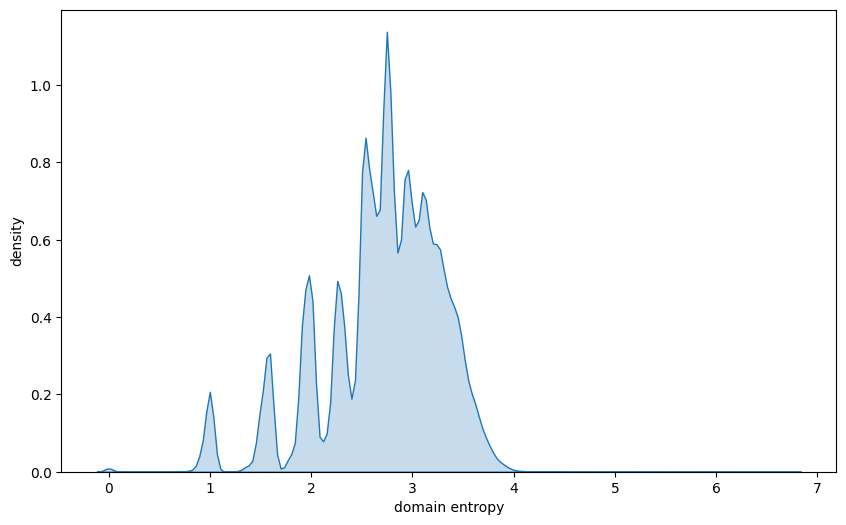

In [ ]:
# visualize domain entropy
# we see higher numbers than hostname because hostname includes many consistent characters such as 'www.' and '.com'
plt.figure(figsize=(10, 6))
sns.kdeplot(features['domain_entropy'], shade=True)
plt.xlabel('domain entropy')
plt.ylabel('density')
plt.show()

In [ ]:
# extract type of top-level domain
# features['tld'] = df['url'].apply(lambda x: int(tldextract.extract(x).suffix in ['info', 'tk']))
# features.head()

In [ ]:
# extract tld and length of tld
features['tld'] = df['url'].apply(lambda x: tldextract.extract(x).suffix)
# print(features[features['tld'] != ''])
features['tld_length'] = features['tld'].apply(len)

In [ ]:
# binary features (returns either 0 or 1)

In [ ]:
# extract whether a url has 'http' in it
def http(url):
    scheme = urlparse(url).scheme
    match = str(scheme)
    if match=='http':
        return 1
    else:
        return 0

features['http'] = df['url'].apply(lambda x: http(x))

In [ ]:
# extract whether a url has 'https' in it
def https(url):
    scheme = urlparse(url).scheme
    match = str(scheme)
    if match=='https':
        return 1
    else:
        return 0

features['https'] = df['url'].apply(lambda x: https(x))

In [ ]:
# extract whether a url contains suspicious keywords
def sus_words(url):
    match = re.search('password|login|signin|bank|account|update|free|lucky|service|bonus|official|verify|confirm|secure|pay|reset',
                      url)
    if match:
        return 1
    else:
        return 0
features['sus_words'] = df['url'].apply(lambda x: sus_words(x))

In [ ]:
feature_names = features.columns.tolist()
feature_names

['url_length',
 'letter_count',
 'digit_count',
 '@',
 '?',
 '-',
 '=',
 '.',
 '#',
 '%',
 '+',
 '$',
 '!',
 '*',
 ',',
 '/',
 '//',
 'path_length',
 'fd_length',
 'url_entropy',
 'hostname',
 'hostname_length',
 'hostname_entropy',
 'domain',
 'domain_length',
 'domain_entropy',
 'tld',
 'tld_length',
 'http',
 'https',
 'sus_words']

In [ ]:
features

,url_length,letter_count,digit_count,@,?,-,=,.,#,%,...,hostname_length,hostname_entropy,domain,domain_length,domain_entropy,tld,tld_length,http,https,sus_words
0,16,13,0,0,0,1,0,2,0,0,...,0,0.000000,br-icloud,9,3.169925,com.br,6,0,0,0
1,35,29,1,0,0,0,0,2,0,0,...,0,0.000000,mp3raid,7,2.807355,com,3,0,0,0
2,31,25,1,0,0,0,0,2,0,0,...,0,0.000000,bopsecrets,10,2.921928,org,3,0,0,0
3,84,60,7,0,1,1,4,2,0,0,...,17,3.146286,garage-pirenne,14,2.896292,be,2,1,0,0
4,235,199,22,0,1,1,3,2,0,0,...,23,3.501398,adventure-nicaragua,19,3.405822,net,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,39,21,12,0,0,0,0,3,0,0,...,0,0.000000,ign,3,1.584963,com,3,0,0,0
651187,44,29,7,0,0,2,0,2,0,0,...,0,0.000000,teamxbox,8,2.750000,com,3,0,0,0
651188,38,30,3,0,0,0,0,1,0,0,...,0,0.000000,gamespot,8,3.000000,com,3,0,0,0
651189,45,36,0,0,0,0,0,2,0,0,...,0,0.000000,wikipedia,9,2.641604,org,3,0,0,0


<ipython-input-36-3e87579582df>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(features.corr(), annot=True, vmin=-1, vmax=1, center=0)


<Axes: >

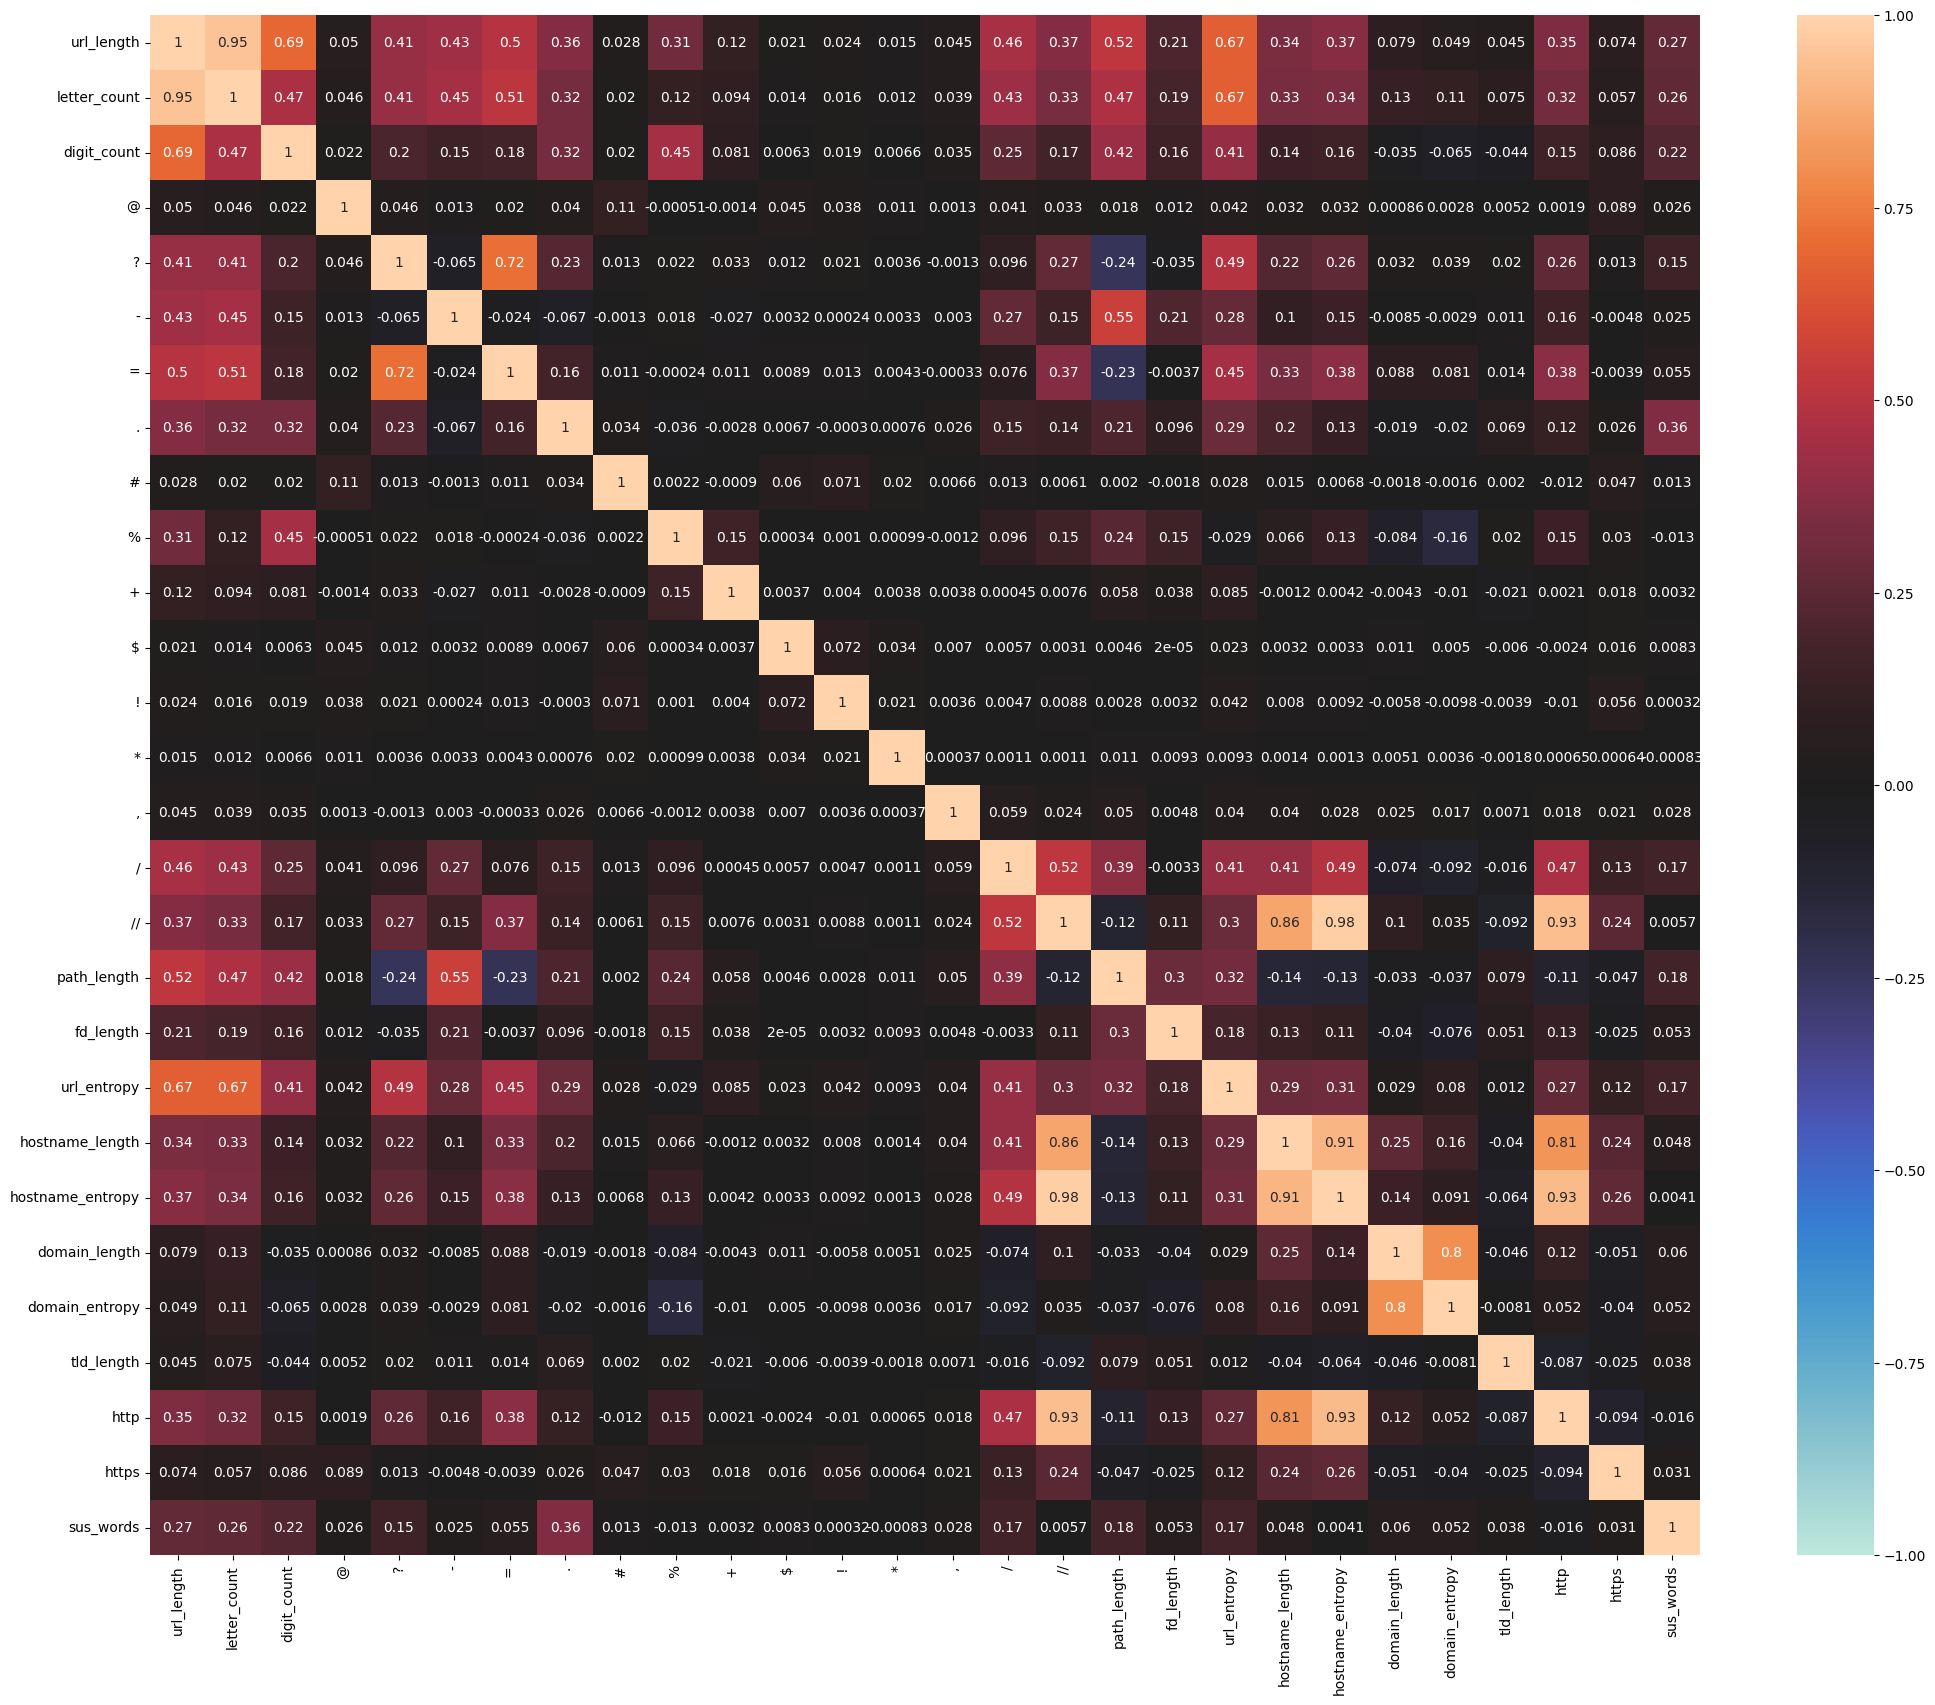

In [ ]:
plt.figure(figsize=(25,20))
sns.heatmap(features.corr(), annot=True, vmin=-1, vmax=1, center=0)

In [ ]:
X, y = features.drop(columns=['domain', 'tld', 'hostname']), df['type']

# normalize the features with MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X)

print(scaled_features)

# assign the new scaled X
X = scaled_features

[[0.00689972 0.00607193 0.         ... 0.         0.         0.        ]
 [0.01563937 0.01354507 0.00083056 ... 0.         0.         0.        ]
 [0.01379945 0.01167679 0.00083056 ... 0.         0.         0.        ]
 ...
 [0.01701932 0.01401214 0.00249169 ... 0.         0.         0.        ]
 [0.02023919 0.01681457 0.         ... 0.         0.         0.        ]
 [0.01655934 0.01541336 0.         ... 0.         0.         0.        ]]


In [ ]:
print(X.shape)
print(y.shape)

(651191, 28)
(651191,)


In [ ]:
# Class balance before under sampling
y.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [ ]:
# Bring malware up to same level as defacement and phishing
from imblearn.over_sampling import RandomOverSampler

sampling_strategy = {'malware': 94000}

oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_oversampled, y_oversampled = oversampler.fit_resample(X, y)


In [ ]:
# Class balance after over-sampling 'malware'
y_oversampled.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        94000
Name: type, dtype: int64

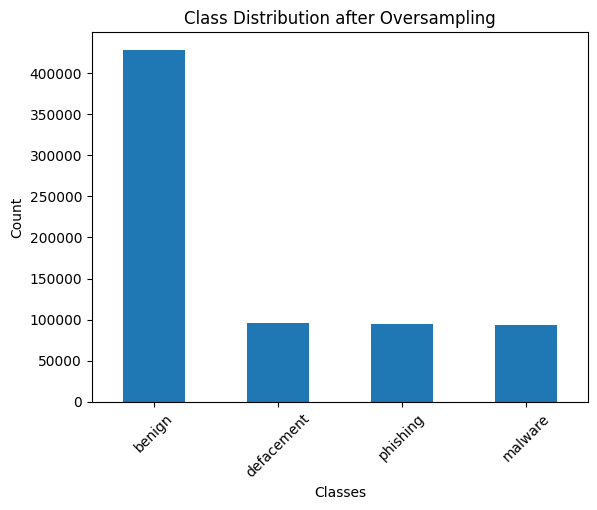

In [ ]:
class_counts = pd.Series(y_oversampled).value_counts()

# Plot the class distribution

class_counts.plot.bar()
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution after Oversampling')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Bring down benign to match totals of non-benign classes (96457+94111+94000=284568)
# Under sampling using RandomUnderSampler
from imblearn.under_sampling import RandomUnderSampler

# We bring 'benign' down to 95000
sampling_strategy = {
    'benign': 284568
}

# Create an instance of RandomUnderSampler
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy)

X_undersampled, y_undersampled = under_sampler.fit_resample(X_oversampled, y_oversampled)

# checking the sizes of the sample data
print("Size of x-sample :", X_undersampled.shape)
print("Size of y-sample :", y_undersampled.shape)

Size of x-sample : (569136, 28)
Size of y-sample : (569136,)


In [ ]:
# Class balance after under sampling
# Now, benign vs. non-benign is balanced.
y_undersampled.value_counts()

benign        284568
defacement     96457
phishing       94111
malware        94000
Name: type, dtype: int64

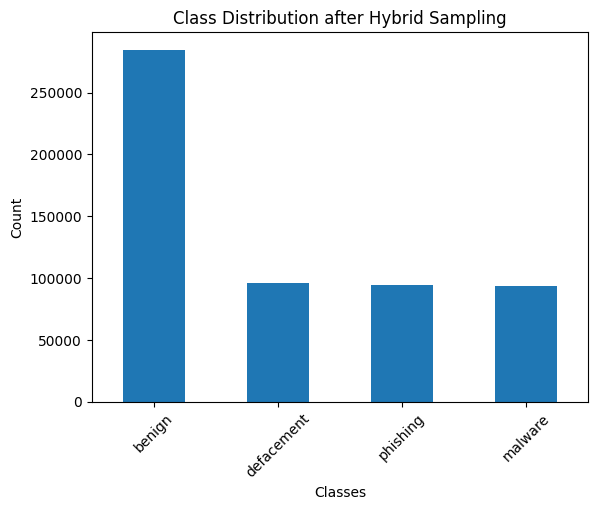

In [ ]:
class_counts = pd.Series(y_undersampled).value_counts()

# Plot the class distribution

class_counts.plot.bar()
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Class Distribution after Hybrid Sampling')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# GaussianNB Model
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size = 0.2, random_state = 31)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model = GaussianNB()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_NB = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_NB)
report_NB = classification_report(y_test, y_pred, output_dict=True)
print(report_NB)

(455308, 28)
(113828, 28)
(455308,)
(113828,)
Accuracy: 0.6949168921530731
{'benign': {'precision': 0.7917807802324873, 'recall': 0.9100591095099857, 'f1-score': 0.8468097570501033, 'support': 57182}, 'defacement': {'precision': 0.5149723234777913, 'recall': 0.9971244837141214, 'f1-score': 0.6791780919482925, 'support': 19127}, 'malware': {'precision': 0.7516110134739309, 'recall': 0.3430664741430023, 'f1-score': 0.4711022985973416, 'support': 18699}, 'phishing': {'precision': 0.6215469613259669, 'recall': 0.08368756641870351, 'f1-score': 0.1475133464456308, 'support': 18820}, 'accuracy': 0.6949168921530731, 'macro avg': {'precision': 0.6699777696275441, 'recall': 0.5834844084464532, 'f1-score': 0.5361508735103421, 'support': 113828}, 'weighted avg': {'precision': 0.7105226513644932, 'recall': 0.6949168921530731, 'f1-score': 0.6413031763178871, 'support': 113828}}


In [ ]:
# Random Forest Model
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size = 0.2, random_state = 31)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy_RF = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_RF}")
report_RF = classification_report(y_test, y_pred, output_dict=True)
print(report_RF)

(455308, 28)
(113828, 28)
(455308,)
(113828,)
Accuracy: 0.9430895737428401
{'benign': {'precision': 0.934556388945199, 'recall': 0.9674722814871812, 'f1-score': 0.9507295193249582, 'support': 57182}, 'defacement': {'precision': 0.9825257731958763, 'recall': 0.9965493804569456, 'f1-score': 0.9894878916084824, 'support': 19127}, 'malware': {'precision': 0.9924646105818397, 'recall': 0.9860955131290443, 'f1-score': 0.9892698106121571, 'support': 18699}, 'phishing': {'precision': 0.8723953641986429, 'recall': 0.7719447396386823, 'f1-score': 0.8191018521128746, 'support': 18820}, 'accuracy': 0.9430895737428401, 'macro avg': {'precision': 0.9454855342303895, 'recall': 0.9305154786779634, 'f1-score': 0.937147268414618, 'support': 113828}, 'weighted avg': {'precision': 0.9418521840326648, 'recall': 0.9430895737428401, 'f1-score': 0.9418104800421356, 'support': 113828}}


In [ ]:
# Create a figure and axes
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size if needed
sns.heatmap(cm.T, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(class_labels)) + 0.5, class_labels)
plt.yticks(np.arange(len(class_labels)) + 0.5, class_labels)

# Display the plot
plt.show()

NameError: ignored

<Figure size 800x600 with 0 Axes>

In [ ]:
# Decision Tree Classifier
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size = 0.2, random_state = 31)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

dt_classifier = DecisionTreeClassifier()

dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)

accuracy_DT = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_DT}")
report_DT = classification_report(y_test, y_pred, output_dict=True)
print(report_DT)

In [ ]:
# MLP Model

# For the MLP Model we must encode and reshape the label column
data = np.array(df['type']).reshape(-1, 1)
encoder = OneHotEncoder()
data_encoded = encoder.fit_transform(data)
data_encoded = data_encoded.toarray()

X, y = features.drop(columns=['domain', 'tld', 'hostname']), data_encoded

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 31)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

model = Sequential()

model.add(Dense(128, activation='relu', input_dim=X.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))  # 4 is the number of classes

optimizer = Adam(lr=0.1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test))


# Must convert X_test to match same type as y variables
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
accuracy_MLP = accuracy_score(y_true_labels, y_pred)
print(f"Accuracy: {accuracy_MLP}")
report_MLP = classification_report(y_true_labels, y_pred, output_dict=True)
print(report_MLP)

(520952, 28)
(130239, 28)
(520952, 4)
(130239, 4)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3712      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 14,180
Trainable params: 14,180
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5210/5210 [==============================] - 15s 3ms/step - loss: 0.3368 - accuracy: 0.8767 - val_loss: 0.2700 - val_accuracy: 0.8985
Epoch 2/50
5210/5210 [=================

In [ ]:
output = pd.DataFrame({"Model":['Gaussian NB','Random Forest',
                                'Decision Tree','MLP'],
                      "Accuracy":[accuracy_NB, accuracy_RF, accuracy_DT, accuracy_MLP]})

In [ ]:
output

,Model,Accuracy
0,Gaussian NB,0.695426
1,Random Forest,0.944003
2,Decision Tree,0.919782
3,MLP,0.926466


In [ ]:
# Model Comparison Table

# Define the models and their corresponding reports
models = ['Gaussian NB', 'Random Forest', 'Decision Tree', 'MLP']
reports = [report_NB, report_RF, report_DT, report_MLP]

# Create an empty dataframe to store the results
columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score']
df_results = pd.DataFrame(columns=columns)

# Iterate over each model and generate the results table
for model, report in zip(models, reports):
    accuracy = report['accuracy']
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1_score = report['weighted avg']['f1-score']
    
    # Create a temporary dataframe with the current model's results
    df_temp = pd.DataFrame([[model, accuracy, precision, recall, f1_score]], columns=columns)
    
    # Concatenate the temporary dataframe with the results dataframe
    df_results = pd.concat([df_results, df_temp], ignore_index=True)

# Print the results table
print(df_results)


           Model  Accuracy  Precision    Recall  F1-Score
0    Gaussian NB  0.695426   0.713111  0.695426  0.640312
1  Random Forest  0.944003   0.942808  0.944003  0.942695
2  Decision Tree  0.919782   0.919555  0.919782  0.919661
3            MLP  0.926466   0.924223  0.926466  0.921298


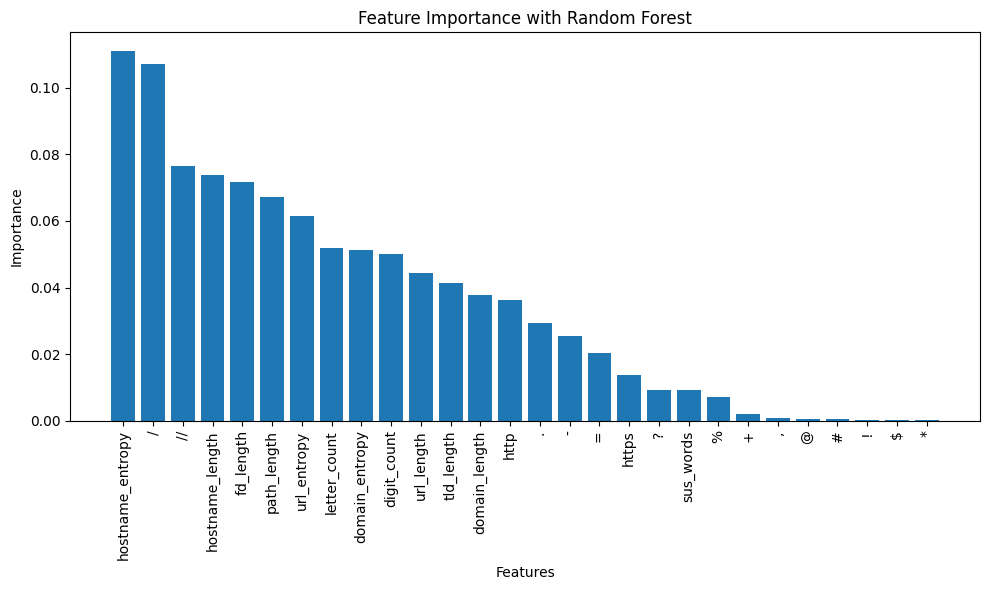

In [ ]:
# Feature Importances Graph

X, y = features.drop(columns=['domain', 'tld', 'hostname']), df['type']

feature_importances = rf_classifier.feature_importances_
feature_names = X.columns.values

# Sort the feature importances in descending order
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the bar chart
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance with Random Forest')
plt.tight_layout()
plt.show()


In [ ]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Optuna implementation
import optuna

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 31)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

def func(trial):
  # Specify the options for each layer
  learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01, 0.1])
  # dropout_rate = trial.suggest_categorical('dropout_rate', [0.2, 0.3, 0.4])
  neurons_layer1 = trial.suggest_categorical('neurons_layer1', [32, 64, 128])
  neurons_layer2 = trial.suggest_categorical('neurons_layer2', [16, 32, 64])

  mlp = MLPClassifier(solver = 'adam',
                      random_state = 91,
                      activation = 'logistic',
                      alpha=0.0001,
                      learning_rate_init = learning_rate,
                      batch_size = 32,
                      hidden_layer_sizes = (neurons_layer1, neurons_layer2),
                      max_iter = 100)
  mlp.fit(X_train, y_train)
  y_pred = mlp.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(func, n_trials=50)

best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)


[I 2023-05-30 18:13:37,142] A new study created in memory with name: no-name-48246a74-23ec-4302-962e-dcd0077e070c


(254470, 27)
(63618, 27)
(254470,)
(63618,)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-05-30 18:18:35,042] Trial 0 finished with value: 0.8646609450155617 and parameters: {'learning_rate': 0.01, 'neurons_layer1': 32, 'neurons_layer2': 16}. Best is trial 0 with value: 0.8646609450155617.
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
[I 2023-05-30 18:23:25,214] Trial 1 finished with value: 0.8551039014115502 and parameters: {'learning_rate': 0.001, 'neurons_layer1': 32, 'neurons_layer2': 32}. Best is trial 0 with value: 0.8646609450155617.
[I 2023-05-30 18:24:36,077] Trial 2 finished with value: 0.8289320632525385 and parameters: {'learning_rate': 0.1, 'neurons